# LSA Model

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import os.path

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LsiModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # Author: don't skip this
# pyLDAvis.gensim.prepare

# I think i need another one:
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')
stop_words.extend(['tenlastelegging\\n\\n\\naan', '\\n\\n\\n\\n\\n\\n', '\\n\\n\\n\\n\\n', '\\n\\n', 'een', 'naan', 'nde', 'nhij', '\\n'])

# Data

In [4]:
#df = pd.read_csv('DataSample_DSP_07123.csv', index_col=1) 
#df = df[df['re_tll'] != '[]'][['re_tll']] #re_bewijs
# data = [i for i in df['re_tll']]
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/dataset_10012022.csv', index_col=1) 

df_be = df[df['bewijs'] != '[]'] #bewijs
df_te = df[df['tll'] != '[]'] #tenlastelegging
df_be

,Unnamed: 0,ecli,subject,spatial,case_nr,date,bewijs,tll
filename,,,,,,,,
ECLI_NL_GHSHE_2021_1801.xml,9,ECLI:NL:GHSHE:2021:1801,Strafrecht,'s-Hertogenbosch,20-003457-18,2021-02-10,['[\'\\n\\n\\n\\n\\n\\nbewijsmiddelen\\n\\n\\n...,[]
ECLI_NL_GHARL_2020_820.xml,10,ECLI:NL:GHARL:2020:820,Strafrecht,Leeuwarden,21-001899-19,2020-01-30,"[""['\\n\\n\\n\\n\\n\\nbewijsmiddelen, feiten e...","[""[' tenlastelegging\\n\\n\\naan verdachte is ..."
ECLI_NL_RBROT_2021_2966.xml,24,ECLI:NL:RBROT:2021:2966,Strafrecht,Rotterdam,10.295806.20,2021-02-09,['[\'\\n\\nbewijswaardering\\n\\n\\n4.1.1.\\n\...,[]
ECLI_NL_RBMNE_2019_6577.xml,28,ECLI:NL:RBMNE:2019:6577,Strafrecht,Utrecht,16/018445-18,2019-01-18,"[""['\\n\\n\\nbewijsmiddelen\\n\\n\\n\\n ...","[""['\\n\\n2tenlastelegging\\n\\n\\nde tenlaste..."
ECLI_NL_GHAMS_2018_185.xml,32,ECLI:NL:GHAMS:2018:185,Strafrecht,Amsterdam,23-002003-17,2018-01-24,"[""['\\n\\n\\n\\n\\n\\nbewijsverweren\\n\\n\\n\...",[]
...,...,...,...,...,...,...,...,...
ECLI_NL_RBLIM_2019_553.xml,3415,ECLI:NL:RBLIM:2019:553,Strafrecht,Maastricht,03/700387-18,2019-01-23,"[""['\\n\\n\\n\\n\\nbewijsoverweging\\n\\n\\n\\...","[""[' tenlastelegging\\n\\nde tenlastelegging i..."
ECLI_NL_GHSHE_2020_1165.xml,3418,ECLI:NL:GHSHE:2020:1165,Strafrecht,'s-Hertogenbosch,20-002048-18,2020-01-29,"[""['\\n\\n\\n\\n\\n\\nbewijsmiddelen\\n\\n\\n\...","['[""\\n\\n\\n\\n\\n\\ntenlastelegging\\n\\n\\n..."
ECLI_NL_RBMNE_2019_275.xml,3422,ECLI:NL:RBMNE:2019:275,Strafrecht; Materieel strafrecht,Lelystad,16/659548-18,2019-01-25,"[""['\\n\\n\\n\\n\\nbewijsmiddelen\\n\\n\\n\\n ...","[""['\\n\\n2tenlastelegging\\n\\n\\nde tenlaste..."


# Tokenize 

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df_be['bewijs']))

print(data_words[:1])

[['nbewijsmiddelen', 'nindien', 'tegen', 'dit', 'verkorte', 'arrest', 'beroep', 'in', 'cassatie', 'wordt', 'ingesteld', 'worden', 'de', 'door', 'het', 'hof', 'gebruikte', 'bewijsmiddelen', 'die', 'redengevend', 'zijn', 'voor', 'de', 'opgenomen', 'in', 'een', 'aanvulling', 'op', 'het', 'arrest', 'deze', 'aanvulling', 'wordt', 'dan', 'aan', 'dit', 'arrest', 'gehecht', 'nde', 'beslissing', 'dat', 'het', 'door', 'de', 'verdachte', 'is', 'begaan', 'berust', 'op', 'de', 'feiten', 'en', 'omstandigheden', 'als', 'vervat', 'in', 'de', 'hierboven', 'bedoelde', 'bewijsmiddelen', 'in', 'onderlinge', 'samenhang', 'beschouwd', 'nstrafbaarheid', 'van', 'het', 'nhet', 'wordt', 'als', 'volgt', 'gekwalificeerd', 'novertreding', 'van', 'een', 'voorschrift', 'gesteld', 'krachtens', 'artikel', 'eerste', 'lid', 'van', 'de', 'wet', 'milieubeheer', 'ner', 'zijn', 'geen', 'feiten', 'of', 'omstandigheden', 'aannemelijk', 'geworden', 'die', 'de', 'strafbaarheid', 'van', 'het', 'uitsluiten', 'het', 'feit', 'is', 

# Creating Bigram and Trigram Models

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['nbewijsmiddelen_nindien', 'tegen', 'dit', 'verkorte_arrest', 'beroep', 'in', 'cassatie', 'wordt', 'ingesteld', 'worden', 'de', 'door', 'het', 'hof', 'gebruikte', 'bewijsmiddelen', 'die', 'redengevend', 'zijn', 'voor', 'de', 'opgenomen', 'in', 'een', 'aanvulling', 'op', 'het', 'arrest', 'deze', 'aanvulling', 'wordt', 'dan', 'aan', 'dit', 'arrest_gehecht', 'nde', 'beslissing', 'dat', 'het', 'door', 'de', 'verdachte', 'is', 'begaan_berust', 'op', 'de', 'feiten', 'en', 'omstandigheden', 'als', 'vervat', 'in', 'de', 'hierboven_bedoelde', 'bewijsmiddelen', 'in', 'onderlinge_samenhang_beschouwd', 'nstrafbaarheid', 'van', 'het', 'nhet', 'wordt', 'als', 'volgt_gekwalificeerd', 'novertreding', 'van', 'een', 'voorschrift', 'gesteld', 'krachtens', 'artikel', 'eerste_lid', 'van', 'de', 'wet_milieubeheer', 'ner', 'zijn', 'geen', 'feiten', 'of', 'omstandigheden_aannemelijk_geworden', 'die', 'de', 'strafbaarheid', 'van', 'het', 'uitsluiten', 'het', 'feit', 'is', 'strafbaar_nstrafbaarheid', 'van', 'd

# Remove Stopwords, Make Bigrams and Lemmatize

In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('nl', disable=['parser', 'ner'])

nlp = spacy.load("nl_core_news_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['verkorte_arrest', 'beroep', 'cassatie', 'instellen', 'hof', 'gebruiken', 'bewijsmiddel', 'redengevend', 'opnemen', 'aanvulling', 'arrest', 'aanvulling', 'beslissing', 'verdenken', 'begaan_berust', 'feit', 'omstandigheid', 'vervatten', 'hierboven_bedoelde', 'bewijsmiddel', 'onderlinge_samenhang', 'beschouwen', 'nstrafbaarheid', 'novertreding', 'voorschrift', 'stellen', 'artikel', 'één', 'lid', 'feit', 'omstandigheid', 'aannemelijk_geworden', 'strafbaarheid', 'uitsluiten', 'feit', 'verdenken', 'feit', 'omstandigheid', 'aannemelijk_geworden', 'strafbaarheid', 'verdenken', 'verdenken', 'daarom', 'strafbaar', 'hiervoor', 'leggen_sanctie', 'hof', 'letten', 'aard', 'ernst', 'bewijzen', 'verklaren', 'omstandigheid', 'waaronder', 'persoon', 'verdenken', 'ander', 'onderzoek', 'ter_terechtzitting', 'voren', 'komen', 'daarnaast', 'letten', 'verhouding', 'strafbaar', 'feit', 'uitdrukking_komt', 'hierop_gestelen', 'wettelijk_strafmaximum', 'straf', 'soortgelijk', 'feit', 'opleggen', 'verdenken', 

#  Create the Dictionary and Corpus needed for Topic Modeling

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 2), (7, 1), (8, 1), (9, 2), (10, 1), (11, 2), (12, 1), (13, 7), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 2), (23, 1), (24, 2), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 8), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 2), (66, 14), (67, 3), (68, 2), (69, 1), (70, 2), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 3), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 5), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1

In [10]:
# Id word
id2word[0]

'aannemelijk_geworden'

# Building the Topic Model

In [11]:
from gensim.models import LsiModel
lsi_model = gensim.models.LsiModel(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=5,
                                   chunksize=100, 
                                   power_iters = 10)
pprint(lsi_model.print_topics())
doc_lsi = lsi_model[corpus]

[(0,
  '0.744*"verdenken" + 0.211*"medeverdacht" + 0.210*"naam" + '
  '0.195*"slachtoffer" + 0.150*"rechtbank" + 0.141*"verklaren" + '
  '0.122*"benadelen" + 0.115*"gaan" + 0.107*"feit" + 0.102*"zeggen"'),
 (1,
  '0.588*"bijnaam" + 0.515*"slachtoffer" + 0.309*"medeverdacht" + '
  '-0.220*"bedrijf" + -0.179*"verdenken" + -0.177*"naam" + -0.165*"benadelen" '
  '+ -0.120*"aangever" + 0.116*"zeggen" + 0.094*"auto"'),
 (2,
  '-0.703*"naam" + -0.439*"medeverdacht" + 0.232*"slachtoffer" + '
  '0.200*"verdenken" + -0.134*"bijnaam" + 0.128*"zien" + -0.120*"informatie" + '
  '-0.095*"zeggen" + 0.088*"hof" + 0.084*"feit"'),
 (3,
  '0.401*"zeggen" + -0.325*"benadelen" + -0.318*"slachtoffer" + -0.309*"naam" '
  '+ -0.279*"bijnaam" + 0.244*"gaan" + 0.240*"medeverdacht" + -0.224*"bedrijf" '
  '+ 0.169*"uur" + -0.168*"aangever"'),
 (4,
  '0.386*"naam" + -0.377*"benadelen" + -0.356*"bijnaam" + 0.303*"slachtoffer" '
  '+ -0.298*"bedrijf" + -0.225*"aangever" + -0.194*"zeggen" + -0.187*"euro" + '
  '-0.18

## Coherence score

In [12]:
# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi)


Coherence Score:  0.36291551039240433


## Improve LSA with TFIDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
#corpus = [str (item) for item in corpus]
from gensim import models

tfidf = models.TfidfModel(corpus)

In [15]:
corpus_tfidf = tfidf[corpus]

In [16]:
lsi_tfidf_model = gensim.models.LsiModel(corpus=corpus_tfidf,
                                   id2word=id2word,
                                   num_topics=5,
                                   chunksize=100, 
                                   power_iters = 10)
pprint(lsi_tfidf_model.print_topics())
doc_lsi = lsi_tfidf_model[corpus_tfidf]

[(0,
  '0.306*"slachtoffer" + 0.262*"hof" + 0.197*"aangeefster" + '
  '0.187*"medeverdacht" + 0.151*"benadelen" + 0.135*"aangever" + 0.133*"naam" '
  '+ 0.095*"man" + 0.094*"verbalisant" + 0.089*"getuige"'),
 (1,
  '0.285*"hof" + 0.273*"arrest_vereist" + 0.269*"wet_aanvulling" + '
  '0.255*"arrest_gehecht" + 0.238*"aanvulling" + 0.225*"artikel_deren" + '
  '0.217*"toepassen" + 0.201*"nstrafbaarheid" + 0.197*"overtuiging" + '
  '0.197*"opgave"'),
 (2,
  '-0.411*"aangeefster" + -0.343*"slachtoffer" + 0.242*"benadelen" + '
  '0.177*"hof" + 0.129*"bedrijf" + 0.124*"loods" + 0.114*"drug" + '
  '0.110*"bedrag" + 0.104*"medeverdacht" + 0.099*"geld"'),
 (3,
  '0.654*"aangeefster" + -0.259*"slachtoffer" + -0.241*"aangever" + '
  '0.176*"benadelen" + 0.157*"hof" + -0.144*"garage" + -0.135*"bijnaam" + '
  '-0.116*"mes" + -0.109*"boompaal" + 0.109*"seks"'),
 (4,
  '0.413*"benadelen" + 0.277*"hof" + -0.271*"verkort_vonni" + '
  '-0.237*"kapitein" + -0.219*"drug" + -0.181*"aangeefster" + 0.154*"part

In [17]:
# Compute Coherence Score
coherence_model_lsi_tfidf = CoherenceModel(model=lsi_tfidf_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi_tfidf = coherence_model_lsi_tfidf.get_coherence()
print('\nCoherence Score: ', coherence_lsi_tfidf)


Coherence Score:  0.4345046669568971


In [18]:
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(lsi_tfidf_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

topic_words.head()

,value,word,topic
0,0.306379,slachtoffer,0
1,0.261530,hof,0
2,0.197494,aangeefster,0
3,0.186625,medeverdacht,0
4,0.150692,benadelen,0


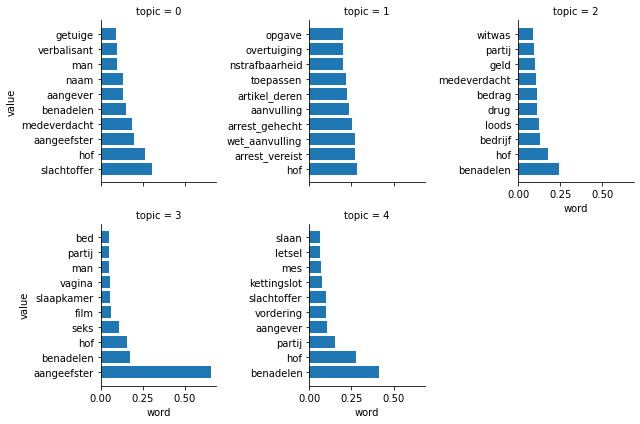

In [19]:
import seaborn as sns

g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")